# Script for calculating and plotting geographical and genetic distance metrics

## Before you begin

In [ ]:
#install.packages("rgdal")
#install.packages("sf")
#install.packages("tidyverse")
#install.packages("cowplot")
#install.packages("reshape2")
install.packages("fasterize")
install.packages("ggthemes")
install.packages("gdistance")
install.packages("rgeos")
install.packages("magick")
install.packages("rlist")

In [ ]:
library(rgdal)
library(tidyverse)
library(sf)
library(fasterize)
library(ggthemes)
library(gdistance)
library(rgeos)
library(cowplot)
library(magick)
library(reshape2)
library(rlist)

## Preparing sample coordinate data and lake raster

In [2]:
setwd("../../")
#Sample coordinates

coords <- read.csv("data/Sample_coordinates_subpop.csv")

coordinates(coords) <- c("long", "lat")
proj4string(coords) <- CRS("+proj=longlat +datum=WGS84")
coords <- spTransform(coords, CRS("+proj=utm +zone=35 ellps=WGS84"))

pts <- SpatialPoints(coords, CRS("+proj=utm +zone=35 ellps=WGS84"))

############################
#Raster

lakes <- read_sf("data/saimaa_map/jarvi_laatikko.shp")
saimaa <- lakes[grep('Saimaa',lakes$Nimi),]

rsaimaa <- raster(saimaa,ncols=576,nrows=717) # The chosen size gives 0.25km spacing
rsaimaa <- fasterize(saimaa,rsaimaa)

r <- rsaimaa
bign <- 100000000
r[is.na(r)] <- bign


trCost <- transition(1/r, mean, directions=8)
trCostC <- geoCorrection(trCost, type="c")


as(<dsCMatrix>, "dgTMatrix") is deprecated since Matrix 1.5-0; do as(as(., "generalMatrix"), "TsparseMatrix") instead



## Find water path and calculate water distance between each pair of samples

In [34]:
dis <- matrix(NA,nrow = 98,ncol = 98)

wpths <- list()
for(i in 1:97){
  for(j in (i+1):98){
    pth <- shortestPath(trCostC, pts[i,], pts[j,], output="SpatialLines")
    dis[i,j] <- 0
    if(length(unlist(coordinates(pth@lines[[1]])))>2) {
      dis[i,j] <- rgeos::gLength(pth)/1000
      pth@lines[[1]]@ID <- paste0(coords$title[i],"-",coords$title[j])
      wpths <- c(wpths,pth)
    }
  }
}

write.table(dis,"results/5.waterdistance/waterdistance.txt",row.names=F,quote=F, col.names=F)

In [35]:
list.save(wpths, 'results/5.waterdistance/wpths.rdata')

## Plot specific water path on map

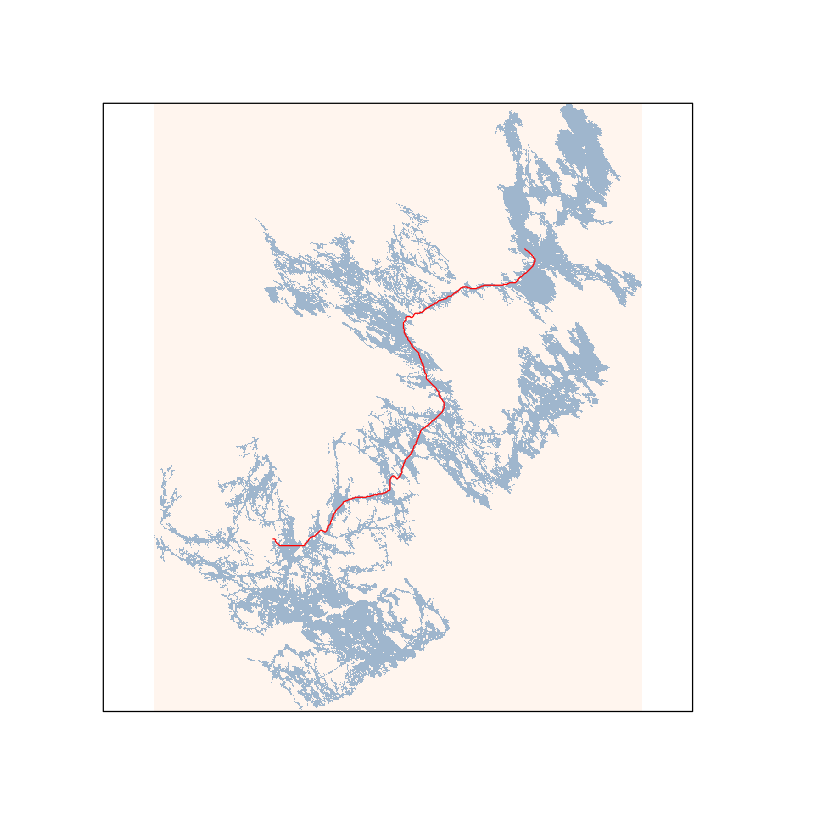

In [36]:
ind <- which(sapply(wpths, function(x) x@lines[[1]]@ID)=="819-1235")    

plot(r, col = c("slategray3", "seashell"), legend = F, axes = F)
plot(wpths[[ind]], col="red", add=TRUE)

## Euclidean distance for comparison

In [37]:
#Converting coords into a dataframe

df <- as.data.frame(coords)

dis = matrix(NA,nrow = 98,ncol = 98)

#Calculating Euclidean distance using dist() function in R
for(i in 1:97){
  for(j in (i+1):98){
    pth=dist(df[c(i,j),3:4], method = "euclidean")
    dis[i,j]=pth/1000    
  }
}

write.table(dis,"results/5.waterdistance/eucdistance.txt",row.names=F,quote=F, col.names=F)


## Gathering distance data to one dataframe

In [3]:
inds <- as.character(read.table("data/saimaa_IDs.txt")$V1)

wdist <- read.table("results/5.waterdistance/waterdistance.txt",row.names=inds,col.names=inds,check.names=F)

wd_melt <- melt(as.matrix(wdist))
wd_melt <- wd_melt[!is.na(wd_melt$value),]
colnames(wd_melt) = c("seal1","seal2","water_distance")

euc <-  read.table("results/5.waterdistance/eucdistance.txt",row.names=inds,col.names=inds,check.names=F)

euc_melt <- melt(as.matrix(euc))
euc_melt <- euc_melt[!is.na(euc_melt$value),]
colnames(euc_melt) = c("seal1","seal2","euclidean_distance")

distances <- merge(wd_melt,euc_melt)

## Plotting distance metrics for selected samples

### Plot both distance metrics on the map of Saimaa 

In [4]:
pairs <- c("2474-2563","2382-2474","2549-2550","2549-2573")

wpths <- list.load('results/5.waterdistance/wpths.rdata')

png(file="results/5.waterdistance/distances_6samples.png",width=1269, height=1500)
par(oma=c(0,0,0,0),mar=c(0,0,0,0))
plot(r, col = c("slategray3", "seashell"), legend = F, axes = F)

for(pair in pairs) {
    pcoord <- coords[coords$title %in% strsplit(pair,"-")[[1]],]
    ind <- which(sapply(wpths, function(x) x@lines[[1]]@ID)==pair)
    plot(wpths[[ind]], add=TRUE, col="slateblue4", lwd = 5)
    points(pcoord, pch=20, col="red", cex = 2.5)
    lines(cbind(pcoord$long,pcoord$lat), lwd = 5, col="red")
    text(pcoord$long, pcoord$lat+3000, labels = pcoord$title, col = "black", cex = 2.5) 
}
dev.off()
                        

png 
  2

### Visualize as barplots

In [5]:
pairs <- c("2474-2563","2474-2382")
pairs <- t(sapply(pairs,function(x) strsplit(x,"-")[[1]]))
               
trio1 <- distances[ distances$seal1 %in% pairs[,1] & distances$seal2 %in% pairs[,2] |
                    distances$seal1 %in% pairs[,2] & distances$seal2 %in% pairs[,1], ]

trio1$seal1[1] <- 2474
trio1$seal2[1] <- 2382
                  
trio1_melt <- melt(trio1,id.vars = c("seal1","seal2"))
                              
pairs <- c("2549-2550","2549-2573")
pairs <- t(sapply(pairs,function(x) strsplit(x,"-")[[1]]))

trio2 <- distances[ distances$seal1 %in% pairs[,1] & distances$seal2 %in% pairs[,2] |
                    distances$seal1 %in% pairs[,2] & distances$seal2 %in% pairs[,1], ]
                  
trio2_melt <- melt(trio2,id.vars = c("seal1","seal2"))

                  
mytheme <- 
    theme_bw() + theme(
        panel.background = element_rect(fill = 'seashell'),
        legend.direction = "horizontal",
        legend.position = "top",
        legend.margin=margin(0,15,0,0), 
        legend.text = element_text(size=10, margin = margin(r = 1.25, l=-4, unit = "pt")),
        legend.key.size = unit(3,"mm"),
        axis.text = element_text(size = 10),
        axis.title = element_text(size = 10) 
    )

               
p1 <- ggplot(data = trio1_melt, aes(x = as.factor(seal2), y = as.numeric(value), fill = variable)) +
  geom_bar(stat = "identity", position = "dodge") +
  xlab("2474") + ylab("Distance") + ylim(0,120) + 
  scale_fill_manual("Distance", labels= c("Water", "Euc."), values=c("slateblue4","lightcoral")) + mytheme 

p2 <- ggplot(data = trio2_melt, aes(x = as.factor(seal2), y = as.numeric(value), fill = variable)) +
  geom_bar(stat = "identity", position = "dodge") +
  xlab("2549") + ylab("Distance") + ylim(0,120) +
  scale_fill_manual("Distance", labels= c("Water", "Euc."), values=c("slateblue4","lightcoral")) + mytheme  


## Comparison between water distance and coancestry

In [6]:
coords2 <- read.csv("data/Sample_coordinates_subpop.csv")

fs_mat <- as.matrix(read.table("results/4.finestructure/datamatrix.txt", header=T, row.names=1, check.names = F))

mean_fs <- (fs_mat+t(fs_mat))/2
mean_fs[upper.tri(mean_fs,diag=TRUE)] <- NA

fs_melt <- melt(as.matrix(mean_fs))
fs_melt <- fs_melt[!is.na(fs_melt$value),]
colnames(fs_melt) <- c("seal1","seal2","coancestry")

fs_distances <- merge(fs_melt,distances)


fs_distances$pop1 <- coords2$pop[match(fs_distances$seal1,coords2$title)]
fs_distances$pop2 <- coords2$pop[match(fs_distances$seal2,coords2$title)]

#Fitting regression models for samples from same subpops, samples from different subpops, and all samples

within <- fs_distances$pop1 == fs_distances$pop2

lim1 <- lm(log10(fs_distances$coancestry[within]) ~ fs_distances$water_distance[within])
lim2 <- lm(log10(fs_distances$coancestry[!within]) ~ fs_distances$water_distance[!within])
lim3 <- lm(log10(fs_distances$coancestry) ~ fs_distances$water_distance)

In [7]:
scatter1 <- 
ggplot(fs_distances, aes(x=water_distance, y=log10(coancestry), color = (pop1==pop2) ))+
  geom_point(alpha=0.25, size = 0.8) + 
  scale_color_manual("Within subpop", values = c('palevioletred3','steelblue'))+
  geom_abline(slope=coef(lim1)[2], intercept = coef(lim1)[1], colour = "steelblue4") +
  geom_abline(slope=coef(lim2)[2], intercept = coef(lim2)[1], colour = "palevioletred4") +
  geom_abline(slope=coef(lim3)[2], intercept = coef(lim3)[1], colour = "black") +
  mytheme

ggsave("results/5.waterdistance/correlation_coancestry.png",scatter1)


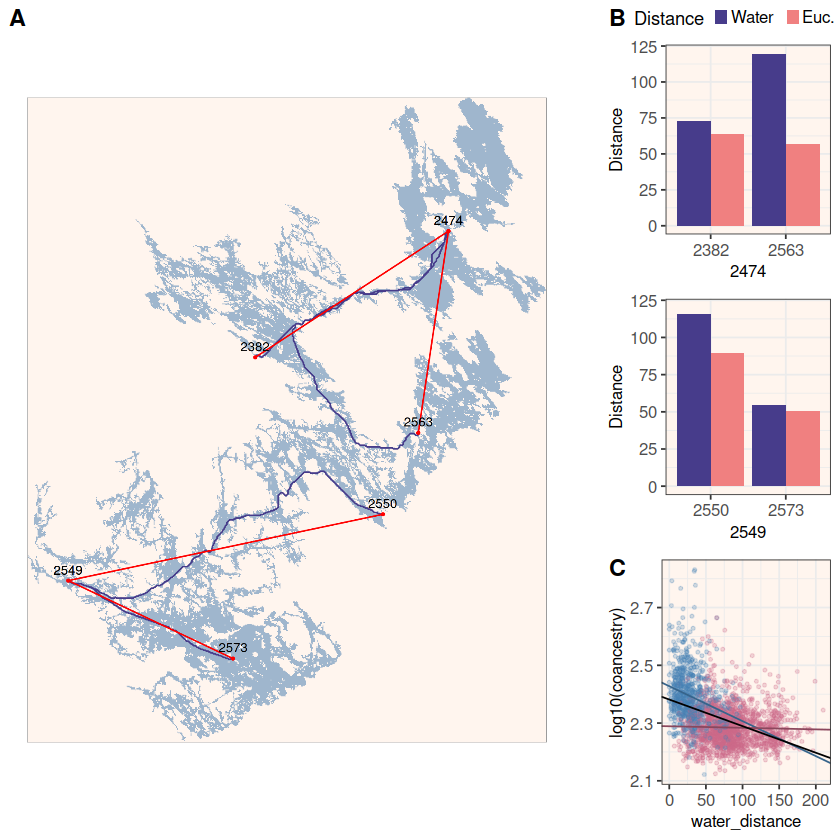

In [8]:
map <- ggplot()+draw_image("results/5.waterdistance/distances_6samples.png",clip=T, x = 0, y = 0) + 
    theme(panel.background = element_rect(fill = 'white'), plot.margin = unit(c(0, 0, 0, 0), "cm"))


plot_grid(map,
    plot_grid(
        p1 + theme(legend.position="top"), p2+ theme(legend.position="none"), scatter1+ theme(legend.position="none"), 
        labels = c("B", "", "C"),
        ncol = 1, nrow = 3, rel_heights = c(1,0.9,1)),
    ncol = 2, nrow=1, rel_widths = c(2.5, 1), labels = c("A", ""))

ggsave("results/5.waterdistance/grid_distance.png",width=9,height=7)
